In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import pearsonr
from scipy.interpolate import griddata


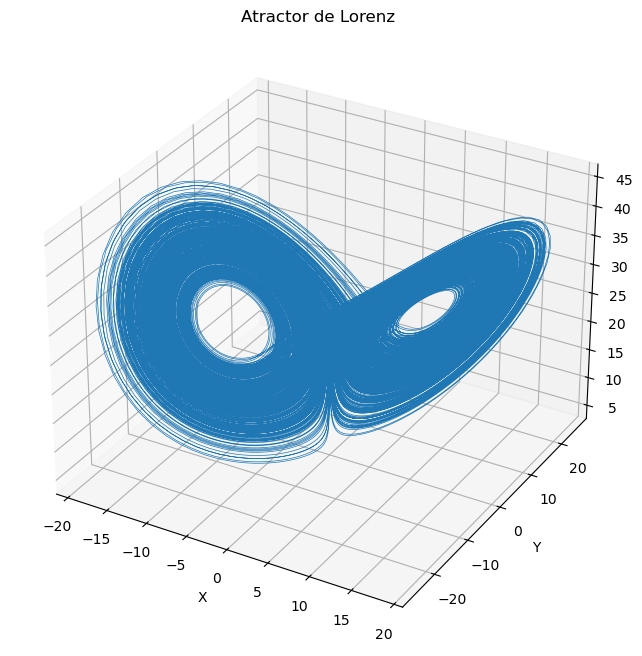

In [3]:
a = 10
b = 28
c = 8/3
dt = 0.01
def Lorenz(t, estado, a, b, c):
    X, Y, Z = estado
    dX = a*(Y - X)
    dY = X*(b - Z) - Y
    dZ = X*Y - c*Z 
    return np.array([dX,dY,dZ])
def rk4(t, estado,dt,a,b,c):
    k1 = Lorenz(t,estado,a,b,c)
    k2 = Lorenz(t + dt/2,estado + dt*k1/2,a,b,c)
    k3 = Lorenz(t + dt/2,estado + dt*k2/2,a,b,c)
    k4 = Lorenz(t + dt,estado + dt*k3,a,b,c)
    nuevo_estado = estado + (dt/6)*(k1+2*k2+2*k3+k4)
    t_nuevo = t + dt
    return t_nuevo, nuevo_estado
t0 = 0.0
estado0_lorenz = np.array([3.0,5.0,9.0])
t_final = 500
t_valores = [t0]
estado_valores_lorenz =[estado0_lorenz]
t = t0
estado_lorenz = estado0_lorenz.copy()
while t < t_final:
    t, estado_lorenz = rk4(t,estado_lorenz, dt ,a,b,c)
    t_valores.append(t)
    estado_valores_lorenz.append(estado_lorenz)
estado_valores_lorenz = np.array(estado_valores_lorenz)
fig = plt.figure(figsize =(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(estado_valores_lorenz[:,0],estado_valores_lorenz[:,1],estado_valores_lorenz[:,2], lw=0.5)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Atractor de Lorenz")
plt.show
x = estado_valores_lorenz[:,0]
y = estado_valores_lorenz[:,1]
z = estado_valores_lorenz[:,2]
#x_lorenz = x[-1500:]
y_lorenz = y[-15000:]
z_lorenz = z[-15000:]
x_lorenz = x[-15000:]

In [8]:

def espacio_fase(series,m,tau):
    #tau : tiempo de retardo
    #E: dimension de embebido
    series = np.array(series)
    N = len(series)
    L = N - (m-1)*tau
    if L <= 0:
        raise ValueError("dimension de embebimiento y/o tiempo de retraso muy grandes para la sere")
    ef_embebido = np.empty((L,m)) #inicializacion espacio de fase embebido
    for i in range (L):
        vector = series[i:i + m * tau : tau] #construye cada vector embebido
        ef_embebido[i,:] = vector[::-1]  
        #les da la vuelta y los ingresa en la matriz del espacio de fase
    return ef_embebido
def informacion_mutua(x, tau, n_bins=None):
    """
    Calcula la información mutua entre la serie x(t) y x(t+lag).
    """
    x = np.asarray(x)
    N = len(x)
    # Regla de Sturges por defecto si no dan n_bins
    if n_bins is None:
        n_bins = int(np.ceil(np.log2(N) + 1))
    # Desfasar
    if tau > 0:
        x1 = x[:-tau]
        x2 = x[ tau:]
    else:
        x1 = x.copy()
        x2 = x.copy()
    # Histograma 2D
    H, _, _ = np.histogram2d(x1, x2, bins=n_bins)
    p_xy = H / H.sum()
    p_x = p_xy.sum(axis=1)
    p_y = p_xy.sum(axis=0)
    # Suma solo donde p_xy>0
    mi = 0.0
    nz = p_xy > 0
    _idx = np.where(nz)
    for i, j in zip(*_idx):
        mi += p_xy[i,j] * np.log(p_xy[i,j] / (p_x[i]*p_y[j]))
    return mi

def grafica_informacion_mutua(x, taus, n_bins=None):
    """
    Para un array de retardos taus, calcula y grafica la información mutua I(x; x_{+tau}).
    Devuelve (taus, mi_values).
    """
    mi_val = [] #lista para guardar los valores de informacion mutua
    for tau in taus:
        mi_val.append(informacion_mutua(x, tau, n_bins))
    mi_val = np.array(mi_val)

    plt.figure(figsize=(8,5))
    plt.plot(taus, mi_val, marker='o', linestyle='-')
    plt.xlabel("Tau (retardo)")
    plt.ylabel("Información mutua")
    plt.title("Información mutua vs. Tau")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return taus, mi_val
def encuentra_tau(x, max_tau=50, n_bins=None):
    taus = np.arange(1, max_tau+1)
    mi = [informacion_mutua(x, tau, n_bins) for tau in taus]
    diffs = np.diff(mi)
    minima = np.where((diffs[:-1] < 0) & (diffs[1:] > 0))[0]
    return taus[minima[0] + 1] if minima.size > 0 else None


def falsos_vecinos(x, max_m, tau, rtol=15.0, atol=2.0, theiler_window=0):
    """
    Implementa Kennel et al. (1992) con exclusión temporal (Theiler window).
    """
    R_att = np.std(x, ddof=0)
    fnn_frac = np.zeros(max_m)

    for m in range(1, max_m+1):
        # Reconstrucción de dimensión m y m+1
        Yd  = espacio_fase(x, m,   tau)
        Yd1 = espacio_fase(x, m+1, tau)
        # Igualar longitudes
        M = min(Yd.shape[0], Yd1.shape[0])
        Yd, Yd1 = Yd[:M], Yd1[:M]

        # Vecino más cercano en dimensión m
        nbrs = NearestNeighbors(n_neighbors=2).fit(Yd)
        dists, idxs = nbrs.kneighbors(Yd)
        R_d = np.maximum(dists[:,1], 1e-12)

        false_count = 0
        for i in range(M):
            j = idxs[i,1]
            # Excluir vecinos demasiado cercanos en tiempo o fuera de rango
            if abs(i - j) < theiler_window or j >= M:
                continue
            # Distancia en dimensión m+1
            R_d1 = np.linalg.norm(Yd1[i] - Yd1[j])
            # Criterios Kennel
            c1 = (R_d1 - R_d[i]) / R_d[i] > rtol
            c2 = R_d1 > atol * R_att
            if c1 or c2:
                false_count += 1

        fnn_frac[m-1] = false_count / M

    return fnn_frac

def encuentra_m(fnn, max_m, threshold=0.003):
    """
    Dada la lista/array de fracciones de FNN (fnn) para m=1..max_m,
    devuelve la menor dimensión m para la cual fnn[m-1] < threshold.
    Si no existe tal m ≤ max_m, devuelve None.

    Parámetros
    ----------
    fnn : array-like de longitud max_m
        Fracción de falsos vecinos para cada dimensión m.
    max_m : int
        Dimensión máxima evaluada (longitud de fnn).
    threshold : float, opcional
        Umbral de fracción para considerar que ya cae a (prácticamente) cero.

    Retorna
    -------
    m_opt : int o None
        Embedding óptimo (1 ≤ m_opt ≤ max_m), o None si no baja de threshold.
    """
    fnn = np.asarray(fnn)
    valid = np.where(fnn < threshold)[0]
    if valid.size > 0:
        m_opt = valid[0] + 1
        return m_opt
    else:
        print(f"No cayó por debajo de {threshold} en m ≤ {max_m}")
        return None
def generar_condiciones_iniciales(
    N,
    x_range=(-20.0, 20.0),
    y_range=(-20.0, 20.0),
    z_range=(0.0, 50.0),
    seed=None
):
    """
    Genera N condiciones iniciales (x0, y0, z0) uniformes en los rangos dados.

    Parámetros
    ----------
    N : int
        Número de condiciones iniciales a generar.
    x_range : tuple(float, float)
        (mínimo, máximo) para x0.
    y_range : tuple(float, float)
        (mínimo, máximo) para y0.
    z_range : tuple(float, float)
        (mínimo, máximo) para z0.
    seed : int or None
        Semilla opcional para reproducibilidad.

    Retorna
    -------
    init_states : ndarray de forma (N, 3)
        Cada fila es [x0, y0, z0].
    """
    if seed is not None:
        np.random.seed(seed)
    x0 = np.random.uniform(x_range[0], x_range[1], size=N)
    y0 = np.random.uniform(y_range[0], y_range[1], size=N)
    z0 = np.random.uniform(z_range[0], z_range[1], size=N)
    return np.vstack((x0, y0, z0)).T

In [6]:
N = 500
condiciones = generar_condiciones_iniciales(N)
print(condiciones.shape)   # (500, 3)
print(condiciones)     # primeras 5 condiciones

(500, 3)
[[  4.14027895  12.01211116  43.01329666]
 [-16.48454437  -3.69062176  39.8619019 ]
 [  9.52408359 -13.04310993  49.35652291]
 ...
 [ -5.87668707   3.51736967  31.06203565]
 [ 12.77351549   4.50989461  32.69546384]
 [ -8.17996893  16.28224503   4.27456949]]


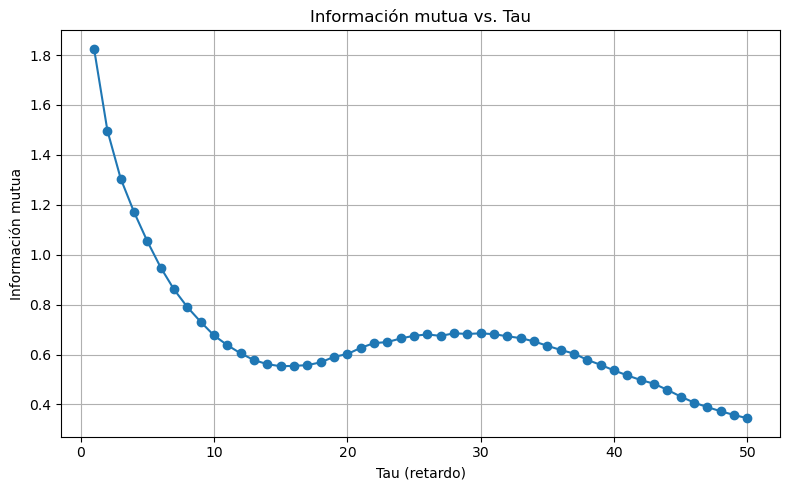

El primer mínimo de información mutua se encuentra en tau = 15


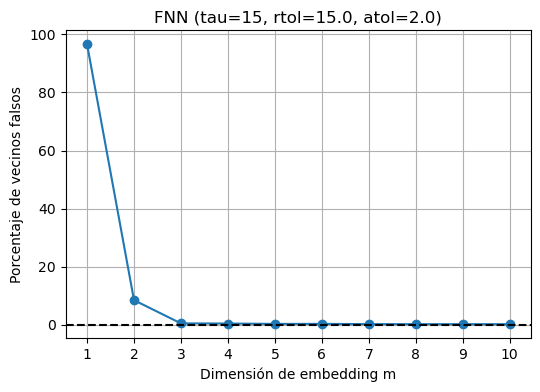

Embedding óptimo m = 5


In [9]:
if __name__ == "__main__":
    taus = np.arange(1, 51)
    taus, mi_values = grafica_informacion_mutua(z_lorenz, taus, n_bins=None)
    diffs = np.diff(mi_values)
    first_min_index = np.where((diffs[:-1] < 0) & (diffs[1:] > 0))[0]
    
    if first_min_index.size > 0:
        optimal_tau = taus[first_min_index[0] + 1]
        print("El primer mínimo de información mutua se encuentra en tau =", optimal_tau)
    else:
        print("No se encontró un mínimo significativo en el rango evaluado.")

   
    # - La idea es que el primer mínimo de la información mutua indica el retardo óptimo, ya que,
    #   para valores de tau muy pequeños la información es redundante y, para tau muy grandes, se pierde correlación.
   # 2) configura parámetros
    max_m = 10
    tau   = 15       # p.ej. primer mínimo de AMI
    rtol  = 15.0
    atol  = 2.0
    tw    = (1/dt) # ventana de 1 unidad de tiempo

    # 3) calcula FNN
    fnn = falsos_vecinos(z_lorenz, max_m, tau, rtol, atol, tw)

    # 4) plot
    plt.figure(figsize=(6,4))
    ms = np.arange(1, max_m+1)
    plt.plot(ms, fnn*100, 'o-', label='FNN %')
    plt.axhline(0, color='k', linestyle='--')
    plt.xlabel('Dimensión de embedding m')
    plt.ylabel('Porcentaje de vecinos falsos')
    plt.title(f'FNN (tau={tau}, rtol={rtol}, atol={atol})')
    plt.xticks(ms)
    plt.grid(True)
    plt.show()

    # 5) encuentra m donde cae a 0%
    valid = np.where(fnn < 0.003)[0]
    if valid.size > 0:
        m_opt = valid[0] + 1
        print("Embedding óptimo m =", m_opt)
    else:
        print("No cayó a cero en m ≤", max_m)

In [10]:
%%time
series_x = []  # aquí se irán metiendo arrays de largo 15000
series_y = []  # aquí se irán metiendo arrays de largo 15000
series_z = []  # aquí se irán metiendo arrays de largo 15000
for idx, estado_0 in enumerate(condiciones):
    # 1) Integramos el Lorenz desde t=0 hasta t_final
    t = t0
    estado_lorenz = estado_0.copy()
    t_valores = [t]
    estado_valores = [estado_0.copy()]

    while t < t_final:
        t, estado_lorenz = rk4(t, estado_lorenz, dt, a, b, c)
        t_valores.append(t)
        estado_valores.append(estado_lorenz.copy())

    estado_valores = np.array(estado_valores)

    # 2) Extraemos la componente x y nos quedamos con los últimos n_keep
    x = estado_valores[:, 0]
    y = estado_valores[:,1]
    z = estado_valores[:,2]
    if len(x) < 15000:
        raise ValueError(f"Para la condición {idx}, la serie solo tiene {len(x)} puntos.")
    x_lorenz = x[-15000:]

    # 3) Guardamos la serie
    series_x.append(x_lorenz)
    if len(y) < 15000:
        raise ValueError(f"Para la condición {idx}, la serie solo tiene {len(y)} puntos.")
    y_lorenz = y[-15000:]
    # 3) Guardamos la serie
    series_y.append(y_lorenz)
    if len(z) < 15000:
        raise ValueError(f"Para la condición {idx}, la serie solo tiene {len(z)} puntos.")
    z_lorenz = z[-15000:]
    # 3) Guardamos la serie
    series_z.append(z_lorenz)

# Ahora `series_x` es una lista de 500 arrays, cada uno de longitud 1500
print(f"Generadas {3*len(series_x)} series de largo {15000} cada una.")

Generadas 3*500 series de largo 15000 cada una.
CPU times: user 12min 26s, sys: 20.4 s, total: 12min 46s
Wall time: 12min 28s


In [ ]:
%%time
taus_x = []
Es_x   = []
taus_y = []
Es_y   = []
taus_z = []
Es_z   = []


for i, x_lorenz in enumerate(series_x):
    # 0) Descarta series con NaN o inf
    if not np.all(np.isfinite(x_lorenz)):
        print(f"Serie {i}: contiene NaN/inf, la salto.")
        continue
    
    # 1) Calcular tau óptimo (dentro de try para capturar errores)
    try:
        tau_opt_x = encuentra_tau(x_lorenz, max_tau=50, n_bins=None)
    except Exception as e:
        print(f"Serie {i}: error en find_optimal_tau: {e!r}")
        continue
    
    if tau_opt_x is None:
        # no encontró mínimo
        continue

    # 2) Calcular dimensión óptima con falsos vecinos
    try:
        fnn_x = falsos_vecinos(x_lorenz, max_m, tau_opt_x, rtol, atol, tw)
        E_opt_x =encuentra_m(fnn_x,20,)
    except Exception as e:
        print(f"Serie {i}: error en falsos_vecinos: {e!r}")
        continue

    if E_opt_x is None:
        # ningún E cumple el criterio
        continue

    # 3) Guardar resultados
    taus_x.append(tau_opt_x)
    Es_x.append(E_opt_x)

# Convertir y calcular estadísticas
taus_x = np.array(taus_x)
Es_x   = np.array(Es_x)

print(f"Validas X: {len(taus_x)} / {len(series_x)} series procesadas correctamente.")
print(f"Tau óptimos X: media={taus_x.mean():.3f}, std={taus_x.std():.3f}")
print(f"E óptimos X:   media={Es_x.mean():.3f}, std={Es_x.std():.3f}")

for j, y_lorenz in enumerate(series_y):
    # 0) Descarta series con NaN o inf
    if not np.all(np.isfinite(y_lorenz)):
        print(f"Serie {j}: contiene NaN/inf, la salto.")
        continue
    
    # 1) Calcular tau óptimo (dentro de try para capturar errores)
    try:
        tau_opt_y = encuentra_tau(y_lorenz, max_tau=50, n_bins=None)
    except Exception as e:
        print(f"Serie {j}: error en find_optimal_tau: {e!r}")
        continue
    
    if tau_opt_y is None:
        # no encontró mínimo
        continue

    # 2) Calcular dimensión óptima con falsos vecinos
    try:
        fnn_y = falsos_vecinos(y_lorenz, max_m, tau_opt_y, rtol, atol, tw)
        E_opt_y =encuentra_m(fnn_y,20,)
    except Exception as e:
        print(f"Serie {j}: error en falsos_vecinos: {e!r}")
        continue

    if E_opt_y is None:
        # ningún E cumple el criterio
        continue

    # 3) Guardar resultados
    taus_y.append(tau_opt_y)
    Es_y.append(E_opt_y)

# Convertir y calcular estadísticas
taus_y = np.array(taus_y)
Es_y   = np.array(Es_y)

print(f"Validas Y: {len(taus_y)} / {len(series_y)} series procesadas correctamente.")
print(f"Tau óptimos Y: media={taus_y.mean():.3f}, std={taus_y.std():.3f}")
print(f"E óptimos Y:   media={Es_y.mean():.3f}, std={Es_y.std():.3f}")

for k, z_lorenz in enumerate(series_z):
    # 0) Descarta series con NaN o inf
    if not np.all(np.isfinite(z_lorenz)):
        print(f"Serie {k}: contiene NaN/inf, la salto.")
        continue
    
    # 1) Calcular tau óptimo (dentro de try para capturar errores)
    try:
        tau_opt_z = encuentra_tau(z_lorenz, max_tau=50, n_bins=None)
    except Exception as e:
        print(f"Serie {k}: error en find_optimal_tau: {e!r}")
        continue
    
    if tau_opt_z is None:
        # no encontró mínimo
        continue

    # 2) Calcular dimensión óptima con falsos vecinos
    try:
        fnn_z = falsos_vecinos(z_lorenz, max_m, tau_opt_z, rtol, atol, tw)
        E_opt_z =encuentra_m(fnn_z,20,)
    except Exception as e:
        print(f"Serie {k}: error en falsos_vecinos: {e!r}")
        continue

    if E_opt_z is None:
        # ningún E cumple el criterio
        continue

    # 3) Guardar resultados
    taus_z.append(tau_opt_z)
    Es_z.append(E_opt_z)

# Convertir y calcular estadísticas
taus_z = np.array(taus_z)
Es_z   = np.array(Es_z)

print(f"Validas Z: {len(taus_z)} / {len(series_z)} series procesadas correctamente.")
print(f"Tau óptimos Z: media={taus_z.mean():.3f}, std={taus_z.std():.3f}")
print(f"E óptimos Z:   media={Es_z.mean():.3f}, std={Es_z.std():.3f}")


Validas X: 500 / 500 series procesadas correctamente.
Tau óptimos X: media=18.110, std=0.677
E óptimos X:   media=3.004, std=0.063


In [12]:
df = pd.DataFrame({
    "tau_x": pd.Series(taus_x),
    "E_x":   pd.Series(Es_x),
    "tau_y": pd.Series(taus_y),
    "E_y":   pd.Series(Es_y),
    "tau_z": pd.Series(taus_z),
    "E_z":   pd.Series(Es_z),
})

print(df.head(10))
print("\nShape del DataFrame:", df.shape)

   tau_x  E_x  tau_y  E_y  tau_z  E_z
0     17    3     16    4   15.0  3.0
1     19    3     17    4   16.0  5.0
2     18    3     16    4   15.0  4.0
3     18    3     16    4   16.0  7.0
4     18    3     16    4   16.0  6.0
5     18    3     16    4   16.0  6.0
6     17    3     16    4   16.0  5.0
7     17    3     16    4   16.0  5.0
8     18    3     16    4   15.0  4.0
9     19    3     17    4   16.0  5.0

Shape del DataFrame: (500, 6)


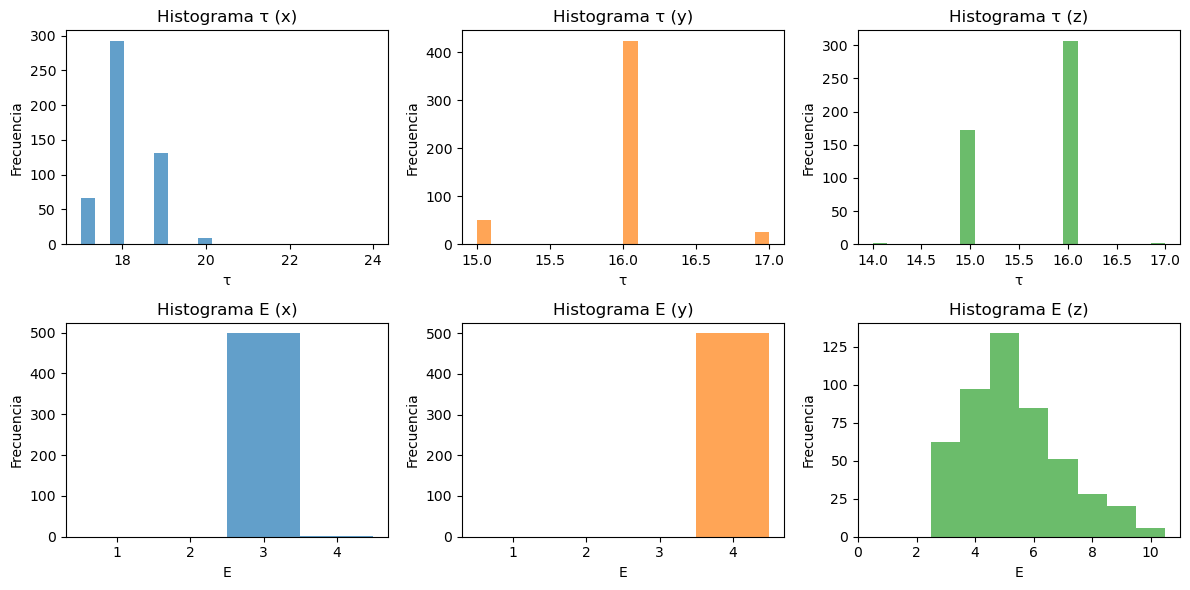

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
variables = ['x', 'y', 'z']
for i, var in enumerate(variables):
    # Tau
    axes[0, i].hist(df[f'tau_{var}'].dropna(), bins=20, color='C'+str(i), alpha=0.7)
    axes[0, i].set_title(f'Histograma τ ({var})')
    axes[0, i].set_xlabel('τ')
    axes[0, i].set_ylabel('Frecuencia')
    # E
    axes[1, i].hist(df[f'E_{var}'].dropna(), bins=range(1, int(df[f'E_{var}'].max())+2),
                    color='C'+str(i), alpha=0.7, align='left')
    axes[1, i].set_title(f'Histograma E ({var})')
    axes[1, i].set_xlabel('E')
    axes[1, i].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()
